### This scripts takes about 4 minutes seconds to execute

In [1]:
from tqdm.notebook import tqdm, trange
import horseracinglib
from horseracinglib import *
from importlib import reload
reload(horseracinglib)
pd.options.display.max_columns = None

# Load test data (not seen by models)

In [2]:
runners = pd.read_csv('data\\runners_test.csv', parse_dates=['meeting_date'], infer_datetime_format=True)
runners.sort_values(by=['race_id', 'runner_id'], inplace=True)
runners.head()

,runner_id,race_id,meeting_date,stall_number,gender,age,trainer_id,trainer_sr,sire_id,sire_sr,dam_id,dam_sr,finpos,win,win_perc,sp,mkt_prob,overage,adj_mkt_prob,blinkers,visor,cheekpieces,tonguetie,entire,gelding,daysLTO,position1,position2,position3,position1_1,position1_2,position1_3,position1_4,position2_1,position2_2,position2_3,position2_4,position3_1,position3_2,position3_3,position3_4
608,568961,440447,2013-01-01,3,G,10,3973,0.189024,50854,0.0,199460,0.0,1,1,0.703704,1.08,0.925926,1.15583,0.801095,0,0,0,0,0,1,15,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0
2819,720097,440447,2013-01-01,1,G,10,9509,0.053333,1213449,0.0,104420,0.0,4,0,0.000000,21.00,0.047619,1.15583,0.041199,0,0,0,0,0,1,365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3087,738609,440447,2013-01-01,2,G,8,9243,0.079691,1217252,0.0,107710,0.0,3,0,0.000000,17.00,0.058824,1.15583,0.050893,0,0,0,0,0,1,225,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0
20189,1663897,440447,2013-01-01,4,G,4,19540,0.128226,261406,0.0,64884,0.0,2,0,0.000000,9.00,0.111111,1.15583,0.096131,0,0,0,0,0,1,14,4,4,2,0,0,0,1,0,0,0,1,0,1,0,0
30270,1783909,440447,2013-01-01,5,G,5,9013,0.011111,485373,0.0,441268,0.0,5,0,0.000000,81.00,0.012346,1.15583,0.010681,0,0,0,0,0,1,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
runners_single_race = runners[runners.race_id == 440447]
runners_single_race

,runner_id,race_id,meeting_date,stall_number,gender,age,trainer_id,trainer_sr,sire_id,sire_sr,dam_id,dam_sr,finpos,win,win_perc,sp,mkt_prob,overage,adj_mkt_prob,blinkers,visor,cheekpieces,tonguetie,entire,gelding,daysLTO,position1,position2,position3,position1_1,position1_2,position1_3,position1_4,position2_1,position2_2,position2_3,position2_4,position3_1,position3_2,position3_3,position3_4
608,568961,440447,2013-01-01,3,G,10,3973,0.189024,50854,0.0,199460,0.0,1,1,0.703704,1.08,0.925926,1.15583,0.801095,0,0,0,0,0,1,15,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0
2819,720097,440447,2013-01-01,1,G,10,9509,0.053333,1213449,0.0,104420,0.0,4,0,0.000000,21.00,0.047619,1.15583,0.041199,0,0,0,0,0,1,365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3087,738609,440447,2013-01-01,2,G,8,9243,0.079691,1217252,0.0,107710,0.0,3,0,0.000000,17.00,0.058824,1.15583,0.050893,0,0,0,0,0,1,225,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0
20189,1663897,440447,2013-01-01,4,G,4,19540,0.128226,261406,0.0,64884,0.0,2,0,0.000000,9.00,0.111111,1.15583,0.096131,0,0,0,0,0,1,14,4,4,2,0,0,0,1,0,0,0,1,0,1,0,0
30270,1783909,440447,2013-01-01,5,G,5,9013,0.011111,485373,0.0,441268,0.0,5,0,0.000000,81.00,0.012346,1.15583,0.010681,0,0,0,0,0,1,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Demonstrate calculating model probabilities for single race

In [4]:
my_multinomial_logit = MultinomialLogitModel('models\\multinomial_logit_coefficients.csv', model_prefix='ML')
display(my_multinomial_logit.model_coefficients)
my_multinomial_logit.calculate_model_probabilities_for_single_race(runners_single_race)

,feature,coefficient
0,age,-0.027801
1,trainer_sr,5.300271
2,daysLTO,-0.000583
3,position1_1,0.548396
4,position1_2,0.539932
5,position1_3,0.324656
6,position1_4,-0.218123
7,position2_1,0.202110
8,position2_2,0.180563
9,position2_3,0.087636


,race_id,runner_id,stall_number,win,mod_prob
608,440447,568961,3,1,0.558904
2819,440447,720097,1,0,0.091615
3087,440447,738609,2,0,0.097166
20189,440447,1663897,4,0,0.152579
30270,440447,1783909,5,0,0.099735


In [5]:
my_random_choice = RandomChoiceModel(model_prefix='RC')
display(my_random_choice.model_coefficients)
my_random_choice.calculate_model_probabilities_for_single_race(runners_single_race)

None

,race_id,runner_id,stall_number,win,mod_prob
608,440447,568961,3,1,0.115019
2819,440447,720097,1,0,0.166370
3087,440447,738609,2,0,0.297226
20189,440447,1663897,4,0,0.082324
30270,440447,1783909,5,0,0.339061


In [6]:
my_favourite_choice = FavouriteChoiceModel(model_prefix='FC')
display(my_favourite_choice.model_coefficients)
my_favourite_choice.calculate_model_probabilities_for_single_race(runners_single_race)

None

,race_id,runner_id,stall_number,win,mod_prob
608,440447,568961,3,1,0.801095
2819,440447,720097,1,0,0.041199
3087,440447,738609,2,0,0.050893
20189,440447,1663897,4,0,0.096131
30270,440447,1783909,5,0,0.010681


# Demonstrate calculating model probabilities for multiple races

In [7]:
my_multinomial_logit.calculate_model_probabilities_for_multiple_races(runners)
my_multinomial_logit.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,440447,568961,3,1,0.558904
1,440447,720097,1,0,0.091615
2,440447,738609,2,0,0.097166
3,440447,1663897,4,0,0.152579
4,440447,1783909,5,0,0.099735


In [8]:
my_random_choice.calculate_model_probabilities_for_multiple_races(runners)
my_random_choice.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,440447,568961,3,1,0.104752
1,440447,720097,1,0,0.371317
2,440447,738609,2,0,0.130174
3,440447,1663897,4,0,0.157267
4,440447,1783909,5,0,0.236490


In [9]:
my_favourite_choice.calculate_model_probabilities_for_multiple_races(runners)
my_favourite_choice.model_probabilities.head()

,race_id,runner_id,stall_number,win,mod_prob
0,440447,568961,3,1,0.801095
1,440447,720097,1,0,0.041199
2,440447,738609,2,0,0.050893
3,440447,1663897,4,0,0.096131
4,440447,1783909,5,0,0.010681


# Demonstrate probability model assessment

In [10]:
my_model_assessment = ProbabilityModelAssessment([my_multinomial_logit, my_random_choice, my_favourite_choice], runners[['race_id', 'runner_id', 'stall_number', 'win', 'adj_mkt_prob']])
display(my_model_assessment.assessment)
my_model_assessment.perform_assessment()

,race_id,runner_id,stall_number,win,adj_mkt_prob,ML_mod_prob,RC_mod_prob,FC_mod_prob
0,440447,568961,3,1,0.801095,0.558904,0.104752,0.801095
1,440447,720097,1,0,0.041199,0.091615,0.371317,0.041199
2,440447,738609,2,0,0.050893,0.097166,0.130174,0.050893
3,440447,1663897,4,0,0.096131,0.152579,0.157267,0.096131
4,440447,1783909,5,0,0.010681,0.099735,0.236490,0.010681
...,...,...,...,...,...,...,...,...
56736,619008,2068719,10,0,0.035416,0.067727,0.057240,0.035416
56737,619008,2072533,3,0,0.039986,0.051757,0.120802,0.039986
56738,619008,2106312,4,0,0.082637,0.071175,0.105905,0.082637
56739,619008,2120288,13,0,0.011100,0.103377,0.080303,0.011100


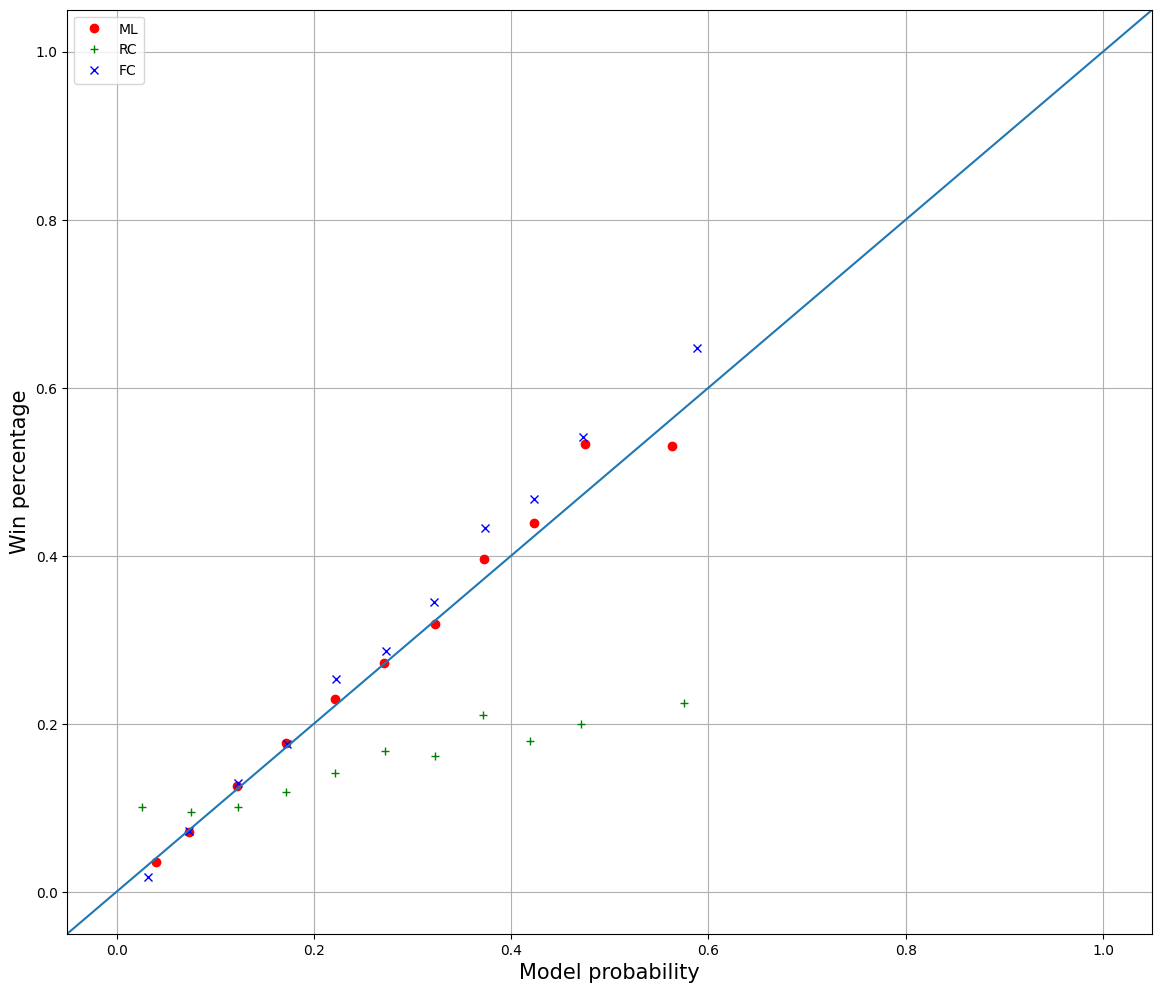

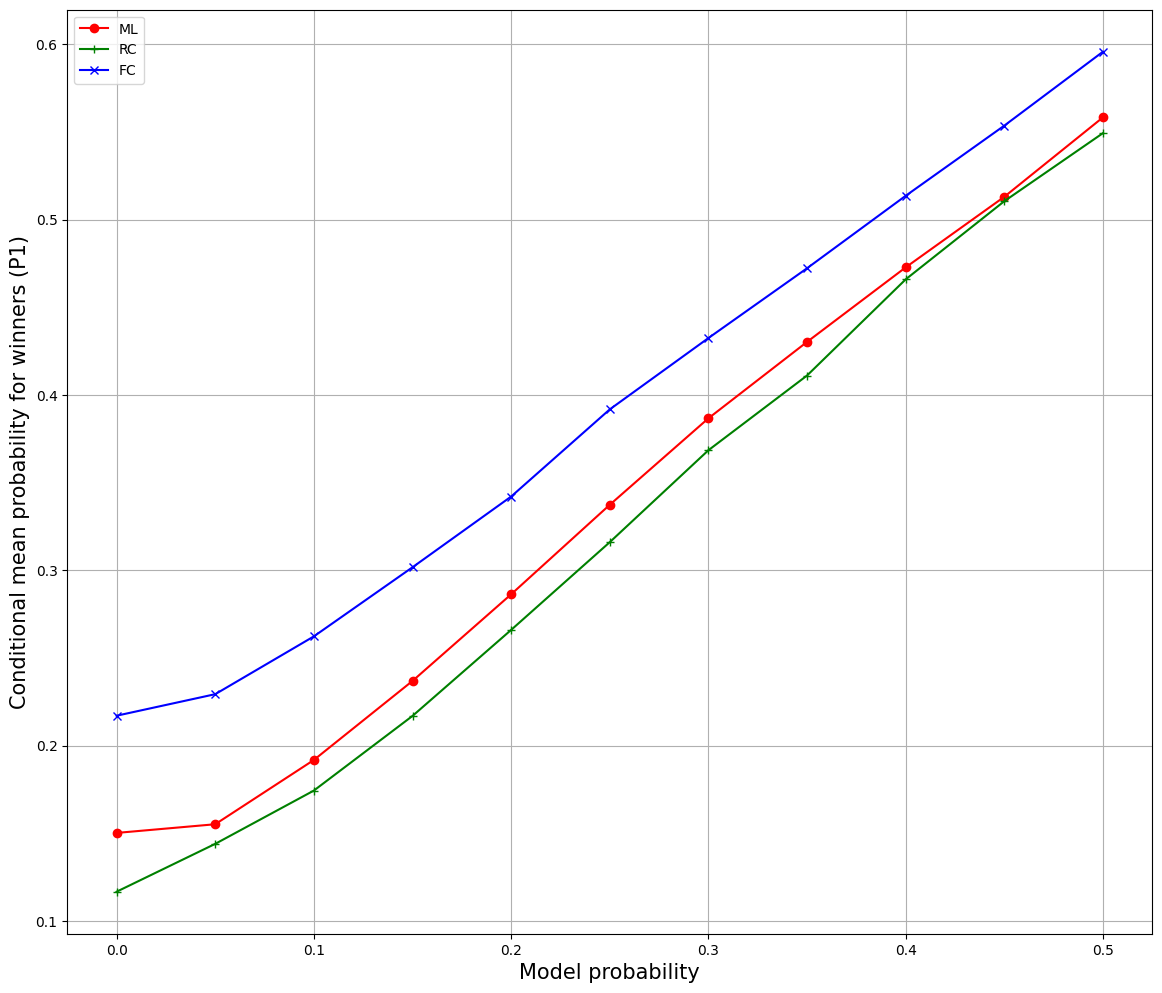

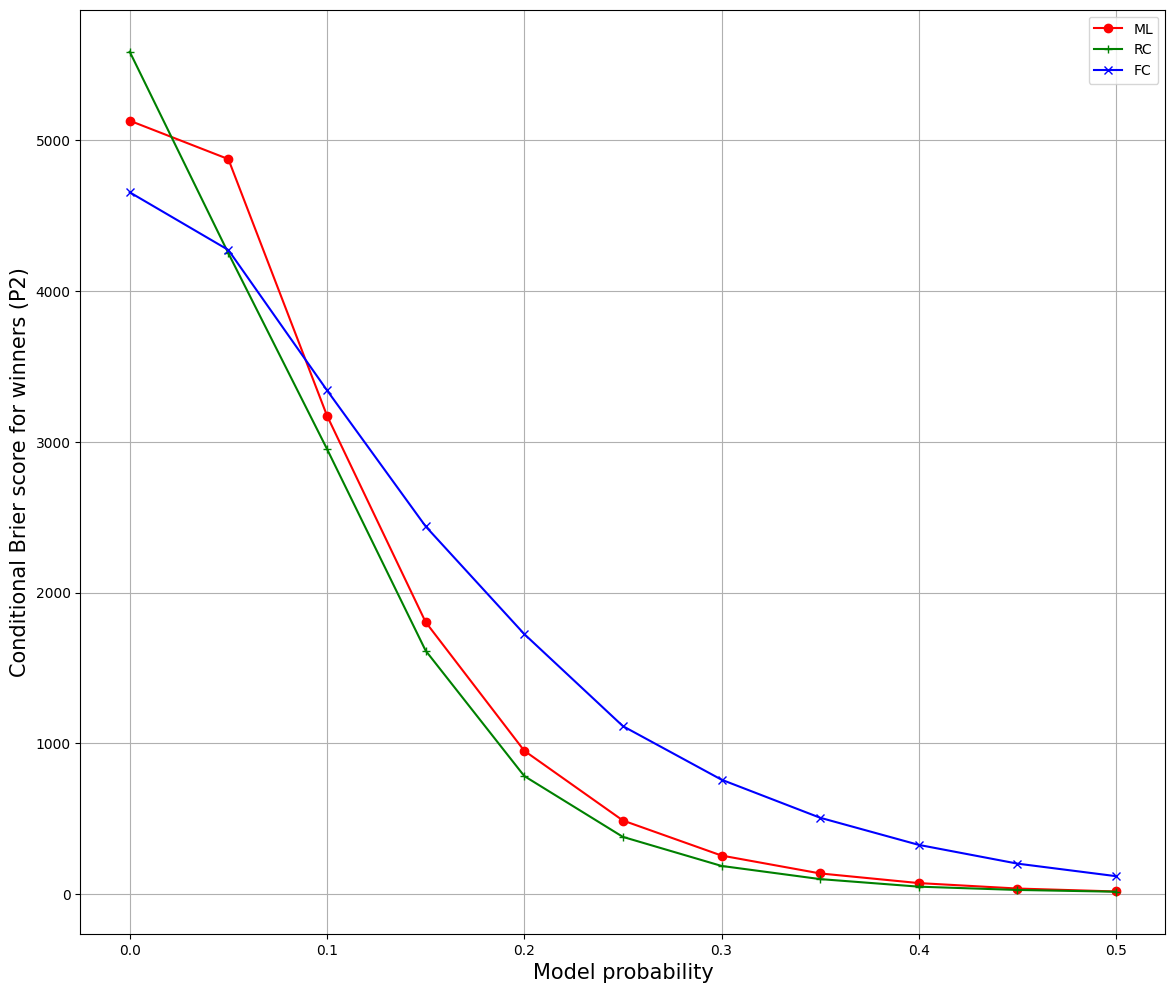

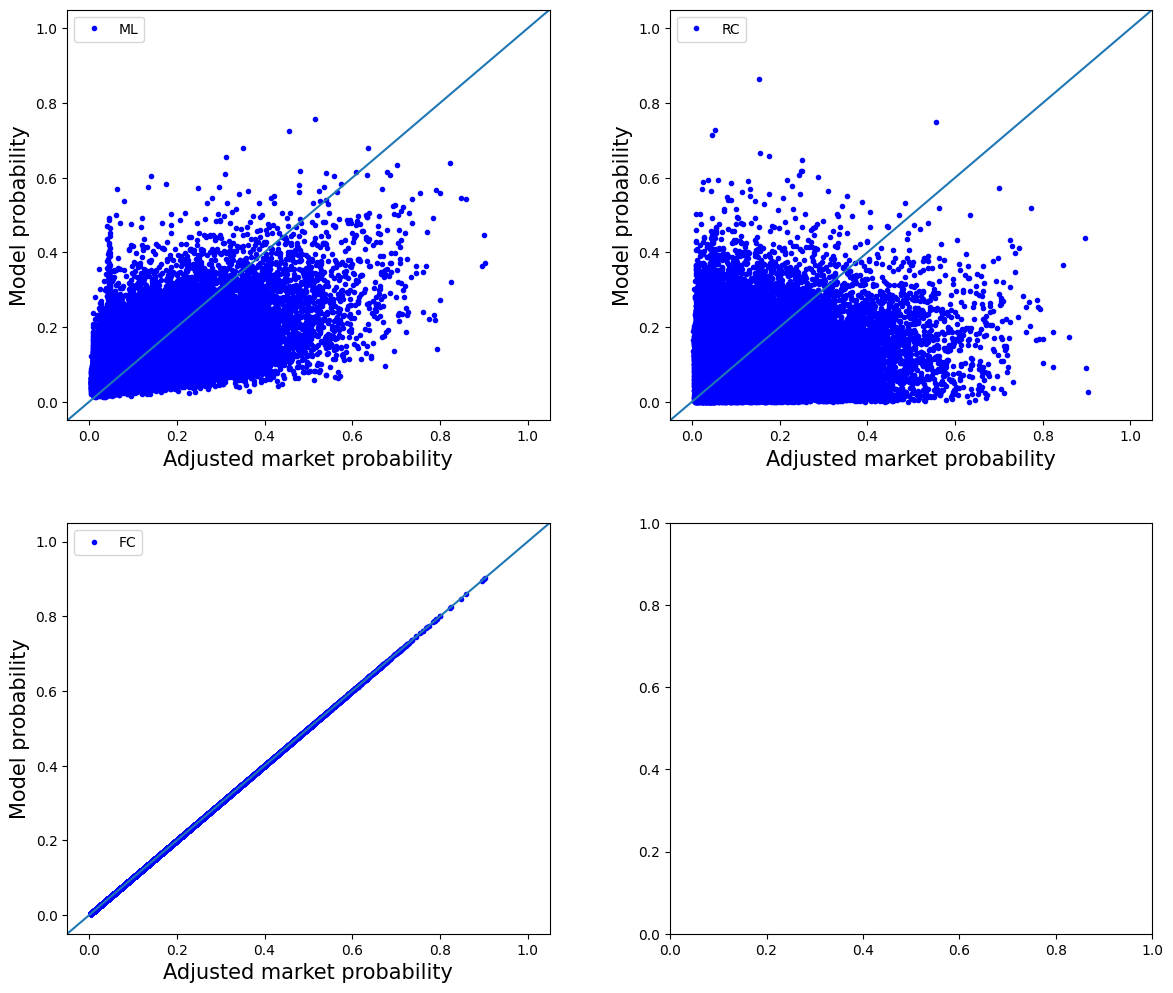

In [11]:
my_model_assessment.show_diagnostic_plots()

# Demonstrate calculating wagering strategy payoffs for single race

In [12]:
def pick_hi_mod_prob(augmented_runners_single_race):
    stakes = pd.Series(np.full(len(augmented_runners_single_race), 0, np.float64), index=augmented_runners_single_race.index)
    max_mod_prob = np.max(augmented_runners_single_race.mod_prob)
    i = augmented_runners_single_race[augmented_runners_single_race.mod_prob == max_mod_prob].index[0]
    stakes[i] = 1
    return stakes

def pick_cond(augmented_runners_single_race):
    return 1 * ((augmented_runners_single_race.mod_prob > 0.15) & (augmented_runners_single_race.mod_prob / augmented_runners_single_race.adj_mkt_prob > 0.13))

In [13]:
my_1st_strategy = WageringStrategy(my_multinomial_logit, pick_hi_mod_prob, 'PickHiModProb')
my_1st_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.558904,1.0,1.08
1,440447,720097,1,21.00,0,0.091615,0.0,0.00
2,440447,738609,2,17.00,0,0.097166,0.0,0.00
3,440447,1663897,4,9.00,0,0.152579,0.0,0.00
4,440447,1783909,5,81.00,0,0.099735,0.0,0.00


In [14]:
my_2nd_strategy = WageringStrategy(my_random_choice, pick_hi_mod_prob, 'PickHiModProb')
my_2nd_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.064099,0.0,0.0
1,440447,720097,1,21.00,0,0.226860,0.0,0.0
2,440447,738609,2,17.00,0,0.145320,0.0,0.0
3,440447,1663897,4,9.00,0,0.202803,0.0,0.0
4,440447,1783909,5,81.00,0,0.360918,1.0,0.0


In [15]:
my_3rd_strategy = WageringStrategy(my_favourite_choice, pick_hi_mod_prob, 'PickHiModProb')
my_3rd_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.801095,1.0,1.08
1,440447,720097,1,21.00,0,0.041199,0.0,0.00
2,440447,738609,2,17.00,0,0.050893,0.0,0.00
3,440447,1663897,4,9.00,0,0.096131,0.0,0.00
4,440447,1783909,5,81.00,0,0.010681,0.0,0.00


In [16]:
my_4th_strategy = WageringStrategy(my_multinomial_logit, pick_cond, 'PickCond')
my_4th_strategy.calculate_strategy_stakes_and_payoffs_for_single_race(runners_single_race)

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.558904,1,1.08
1,440447,720097,1,21.00,0,0.091615,0,0.00
2,440447,738609,2,17.00,0,0.097166,0,0.00
3,440447,1663897,4,9.00,0,0.152579,1,0.00
4,440447,1783909,5,81.00,0,0.099735,0,0.00


# Demonstrate calculating wagering strategy payoffs for multiple races

In [17]:
my_1st_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_1st_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.558904,1.0,1.08
1,440447,720097,1,21.00,0,0.091615,0.0,0.00
2,440447,738609,2,17.00,0,0.097166,0.0,0.00
3,440447,1663897,4,9.00,0,0.152579,0.0,0.00
4,440447,1783909,5,81.00,0,0.099735,0.0,0.00


In [18]:
my_2nd_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_2nd_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.280607,1.0,1.08
1,440447,720097,1,21.00,0,0.054371,0.0,0.00
2,440447,738609,2,17.00,0,0.271671,0.0,0.00
3,440447,1663897,4,9.00,0,0.248470,0.0,0.00
4,440447,1783909,5,81.00,0,0.144880,0.0,0.00


In [19]:
my_3rd_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_3rd_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.801095,1.0,1.08
1,440447,720097,1,21.00,0,0.041199,0.0,0.00
2,440447,738609,2,17.00,0,0.050893,0.0,0.00
3,440447,1663897,4,9.00,0,0.096131,0.0,0.00
4,440447,1783909,5,81.00,0,0.010681,0.0,0.00


In [20]:
my_4th_strategy.calculate_strategy_stakes_and_payoffs_for_multiple_races(runners)
my_4th_strategy.strategy_stakes_and_payoffs.head()

,race_id,runner_id,stall_number,sp,win,mod_prob,strat_stake,strat_payoff
0,440447,568961,3,1.08,1,0.558904,1,1.08
1,440447,720097,1,21.00,0,0.091615,0,0.00
2,440447,738609,2,17.00,0,0.097166,0,0.00
3,440447,1663897,4,9.00,0,0.152579,1,0.00
4,440447,1783909,5,81.00,0,0.099735,0,0.00


# Demonstrate wagering strategy assessment

In [21]:
my_strategy_assessment = WageringStrategyAssessment([my_1st_strategy, my_2nd_strategy, my_3rd_strategy, my_4th_strategy], runners[['race_id', 'meeting_date', 'runner_id', 'stall_number', 'win', 'adj_mkt_prob']])
display(my_strategy_assessment.assessment)
my_strategy_assessment.perform_assessment()

,race_id,meeting_date,runner_id,stall_number,win,adj_mkt_prob,PickHiModProb(ML)_mod_prob,PickHiModProb(ML)_strat_stake,PickHiModProb(ML)_strat_payoff,PickHiModProb(RC)_mod_prob,PickHiModProb(RC)_strat_stake,PickHiModProb(RC)_strat_payoff,PickHiModProb(FC)_mod_prob,PickHiModProb(FC)_strat_stake,PickHiModProb(FC)_strat_payoff,PickCond(ML)_mod_prob,PickCond(ML)_strat_stake,PickCond(ML)_strat_payoff
0,440447,2013-01-01,568961,3,1,0.801095,0.558904,1.0,1.08,0.280607,1.0,1.08,0.801095,1.0,1.08,0.558904,1,1.08
1,440447,2013-01-01,720097,1,0,0.041199,0.091615,0.0,0.00,0.054371,0.0,0.00,0.041199,0.0,0.00,0.091615,0,0.00
2,440447,2013-01-01,738609,2,0,0.050893,0.097166,0.0,0.00,0.271671,0.0,0.00,0.050893,0.0,0.00,0.097166,0,0.00
3,440447,2013-01-01,1663897,4,0,0.096131,0.152579,0.0,0.00,0.248470,0.0,0.00,0.096131,0.0,0.00,0.152579,1,0.00
4,440447,2013-01-01,1783909,5,0,0.010681,0.099735,0.0,0.00,0.144880,0.0,0.00,0.010681,0.0,0.00,0.099735,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56736,619008,2015-10-14,2068719,10,0,0.035416,0.067727,0.0,0.00,0.072294,0.0,0.00,0.035416,0.0,0.00,0.067727,0,0.00
56737,619008,2015-10-14,2072533,3,0,0.039986,0.051757,0.0,0.00,0.051561,0.0,0.00,0.039986,0.0,0.00,0.051757,0,0.00
56738,619008,2015-10-14,2106312,4,0,0.082637,0.071175,0.0,0.00,0.028824,0.0,0.00,0.082637,0.0,0.00,0.071175,0,0.00
56739,619008,2015-10-14,2120288,13,0,0.011100,0.103377,0.0,0.00,0.086249,0.0,0.00,0.011100,0.0,0.00,0.103377,0,0.00


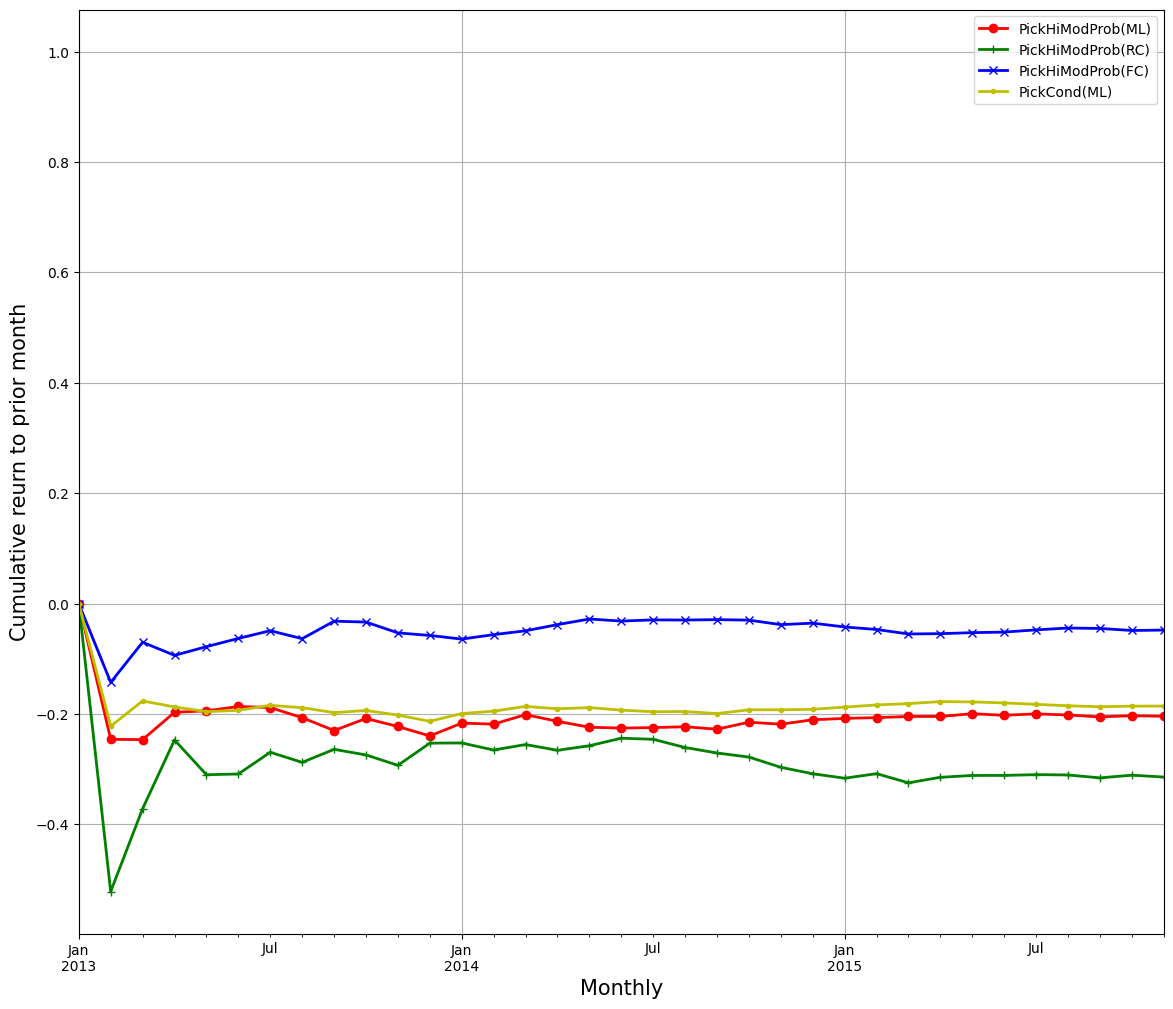

In [22]:
my_strategy_assessment.plot_cumulative_return()

In [23]:
my_strategy_assessment.monthly_assessment['PickHiModProb(ML)']

,as_of,strat_stake,strat_payoff,strat_ret,strat_stake_cumsum,strat_payoff_cumsum,strat_cumret
0,2013-01-01,0.0,0.00,0.000000,0.0,0.00,0.000000
1,2013-02-01,332.0,250.40,-0.245783,332.0,250.40,-0.245783
2,2013-03-01,260.0,195.80,-0.246923,592.0,446.20,-0.246284
3,2013-04-01,278.0,252.52,-0.091655,870.0,698.72,-0.196874
4,2013-05-01,223.0,182.09,-0.183453,1093.0,880.81,-0.194135
5,2013-06-01,100.0,89.93,-0.100700,1193.0,970.74,-0.186303
6,2013-07-01,93.0,73.16,-0.213333,1286.0,1043.90,-0.188258
7,2013-08-01,81.0,40.71,-0.497407,1367.0,1084.61,-0.206576
8,2013-09-01,111.0,53.63,-0.516847,1478.0,1138.24,-0.229878
9,2013-10-01,163.0,161.39,-0.009877,1641.0,1299.63,-0.208026


In [24]:
my_strategy_assessment.monthly_assessment['PickCond(ML)']

,as_of,strat_stake,strat_payoff,strat_ret,strat_stake_cumsum,strat_payoff_cumsum,strat_cumret
0,2013-01-01,0.0,0.00,0.000000,0.0,0.00,0.000000
1,2013-02-01,637.0,495.57,-0.222025,637.0,495.57,-0.222025
2,2013-03-01,498.0,439.41,-0.117651,1135.0,934.98,-0.176229
3,2013-04-01,601.0,476.13,-0.207770,1736.0,1411.11,-0.187149
4,2013-05-01,463.0,357.67,-0.227495,2199.0,1768.78,-0.195643
5,2013-06-01,177.0,148.16,-0.162938,2376.0,1916.94,-0.193207
6,2013-07-01,148.0,142.12,-0.039730,2524.0,2059.06,-0.184208
7,2013-08-01,102.0,71.92,-0.294902,2626.0,2130.98,-0.188507
8,2013-09-01,164.0,108.26,-0.339878,2790.0,2239.24,-0.197405
9,2013-10-01,207.0,177.73,-0.141401,2997.0,2416.97,-0.193537
